# Optics Design for High Time Resolution Measurements with TDS

This tutorial is motivated by a practical task: improving the time resolution of current profile measurements using a Transverse Deflecting Structure (TDS) at the European XFEL (EuXFEL).

---

## A Bit of Simple Theory

The transverse position of a particle along a beamline is given by:

$$
x(s) = A \sqrt{\beta_x(s)} \cos(\Phi_x(s) + \Phi_0)
$$

where:

- $\beta_x(s)$ is the betatron function at position $s$,
- $\Phi_x(s) = \int_{s_0}^{s} \frac{1}{\beta_x(s)} \, ds$ is the betatron phase,
- $\Phi'_x(s) = \frac{1}{\beta_x(s)}$.

Taking the derivative:

$$
x'(s) = -\frac{A}{\sqrt{\beta_x(s)}} \left[ \alpha_x(s) \cos(\Phi_x(s) + \Phi_0) + \sin(\Phi_x(s) + \Phi_0) \right],
$$

with $\alpha_x(s) = -\frac{1}{2} \beta_x'(s)$.

---

### At the TDS Position

Let’s assume the TDS is located at $s = 0$:

- The particle receives a transverse kick: $x'_{\text{tds}} = x'(0)$,
- The transverse position at the TDS is zero: $x(0) = 0$.

Then:

$$
0 = A \sqrt{\beta_x(0)} \cos(\Phi_0) \Rightarrow \Phi_0 = \frac{\pi}{2}
$$

From this, we get:

$$
x'_{\text{tds}} = -\frac{A}{\sqrt{\beta_x(0)}} \Rightarrow A = -x'_{\text{tds}} \sqrt{\beta_x(0)}
$$

---

### At the Screen

The transverse position on the screen becomes:

$$
x(s) = A \sqrt{\beta_x(s)} \cos(\Delta\Phi_x + \Phi_0)
$$

With $\Phi_0 = \frac{\pi}{2}$ and using the identity $\cos(\psi + \pi/2) = -\sin(\psi)$:

$$
x_{\text{scr}} = x'_{\text{tds}} \sqrt{\beta_x(s_{\text{tds}}) \beta_x(s_{\text{scr}})} \sin(\Delta\Phi_x)
$$

---

## Transverse Kick from the Deflecting Structure

The kick from the TDS depends on time:

$$
\Delta x'_{\text{tds}}(t) = \frac{e V_0}{p c} \sin\left( \frac{2\pi c t}{\lambda} + \varphi \right) 
\approx \frac{e V_0}{p c} \left( \frac{2\pi c t}{\lambda} \cos \varphi + \sin \varphi \right)
$$

Assuming $\varphi = 0$ (zero-crossing), the rms beam size on the screen is:

$$
\sigma_x^{\text{scr}} = \frac{e V_0}{p c} \cdot \frac{2\pi c \sigma_t}{\lambda} \cdot \sqrt{\beta_x(s_{\text{tds}}) \beta_x(s_{\text{scr}})} \cdot \sin(\Delta\Phi_x)
$$

---

## Time Resolution of the TDS

### Streaking (Calibration) Factor

The streaking factor is defined as:

$$
S = \frac{\sigma_x^{\text{scr}}}{c \sigma_t} = \frac{e V_0}{p c} \cdot \frac{2\pi}{\lambda} \cdot \sqrt{\beta_x(s_{\text{tds}}) \beta_x(s_{\text{scr}})} \cdot \sin(\Delta\Phi_x)
$$

Note that this expression can be written more compactly by recognizing that the corresponding element of the transfer matrix is:
$$
R_{12} = \sqrt{\beta_x(s_{\text{tds}}) \beta_x(s_{\text{scr}})} \cdot \sin(\Delta\Phi_x)
$$
or, if the streaking occurs in the vertical direction:

$$
R_{34} = \sqrt{\beta_y(s_{\text{tds}}) \beta_y(s_{\text{scr}})} \cdot \sin(\Delta\Phi_y).
$$

Thus, the streaking factor simplifies to:

$$
S = \frac{\sigma_x^{\text{scr}}}{c \sigma_t} = \frac{e V_0}{p c} \cdot \frac{2\pi}{\lambda} \cdot R_{12}
$$


### Time Resolution

The time resolution is defined as:

$$
R_t = \frac{\sigma_{x0}^{\text{scr}}}{c S}
$$

Using $\sigma_{x0}^{\text{scr}} = \sqrt{\varepsilon_x \beta_x(s_{\text{scr}})}$, we get:

$$
R_t = \frac{\sqrt{\varepsilon_x}}{\frac{e V_0}{p} \cdot \frac{2\pi}{\lambda} \cdot \sqrt{\beta_x(s_{\text{tds}})} \cdot \sin(\Delta\Phi_x)}
$$

So the **time resolution depends only on**:

- emittance $\varepsilon_x$
- voltage $V_0$
- wavelength $\lambda$
- beta function at the TDS
- phase advance between TDS and screen

## Practical Example: Optimizing Time Resolution with TDS at EuXFEL

In this section, we apply the theory from the previous part to a real EuXFEL lattice using Ocelot.

In [3]:
import os
import copy
import pandas as pd

from ocelot import *
from ocelot.gui import *
import l2, l3 # lattices can be found in https://github.com/ocelot-collab/EuXFEL-Lattice/tree/main/lattices/longlist_2024_07_04


initializing ocelot...


## Check design optics 

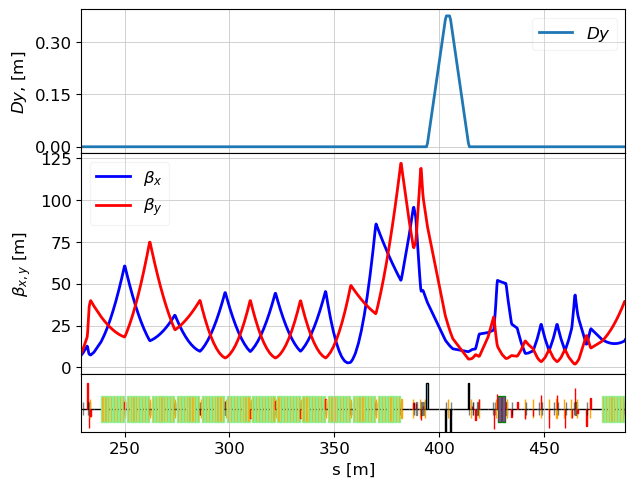

In [2]:
lat_l2 = MagneticLattice(l2.cell + l3.cell, stop=l3.bpmc_488_l3) # id_32072837_ - Drift in front of first A6 RF module
tws = twiss(lat_l2, tws0=l2.tws0)
plot_opt_func(lat_l2, tws, top_plot=["Dy"], legend=False)
plt.savefig("L2_design.png") 
plt.show()


## Check Twiss Parameters at Key Elements

We use markers for the TDS and screens (e.g., `marker_tds_b2`, `otrb_457_b2`) and inspect relevant optics values like beta functions and phase advances.

In [3]:
tws = twiss(lat_l2, tws0=l2.tws0, attach2elem=True)
# with attach2elem=True to all elements will be attached Twiss object in element.tws
# let's print beta_x
print(l2.ensub_466_b2.tws.beta_y)

5.058664837892


## Define Matching Start and End Points

We preserve Twiss parameters at `match_385_b2` (entry point after L2) and `id_32072837_` (end of lattice).

In [4]:
END_ELEM = l3.id_32072837_

tws_match_385 = copy.deepcopy(l2.match_385_b2.tws)
tws_end = copy.deepcopy(END_ELEM.tws)

## Shorten Lattice to Relevant Region

We exclude upstream quadrupoles and start optimization just after L2.

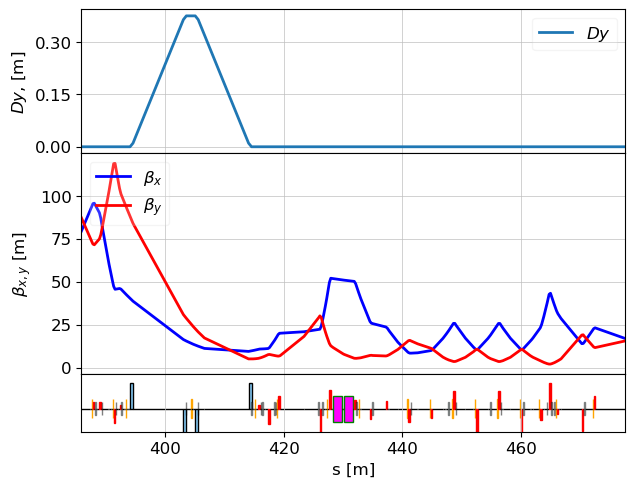

In [5]:
lat = MagneticLattice(l2.cell+l3.cell, start=l2.match_385_b2, stop=END_ELEM)
tws_des = twiss(lat, tws0=tws_match_385)
plot_opt_func(lat, tws_des, top_plot = ["Dy"], legend=False)
plt.savefig("TDS_area_design.png")
plt.show()

#### (Optional) Save Quadrupole Strengths for Reference

We optionally store the design quadrupole strengths in a CSV file for comparison later. The function looks a bit complicated just because I wanted to avoid overwriting every time design quads strengths.

In [6]:
# let's save design kicks to a dictionary
df_filename = "quads_strengths.csv"
design_column = "design"
if os.path.exists(df_filename):
    quads_kicks_df = pd.read_csv(df_filename, index_col=0)
    if design_column in quads_kicks_df.columns:
        print(f"Column '{design_column}' already exists. Skipping step.")
    else:
        print(f"Column '{design_column}' not found. Proceeding to add it.")
        quads_kicks_df[design_column] = pd.Series(d_design)
        df.to_csv(df_filename)
else:
    print("File does not exist. Creating new DataFrame.")
    # let's save design kicks to a dictionary
    d_design = {}
    for e in lat.sequence:
        if e.__class__ == Quadrupole:
            d_design[e.id] = e.k1
    quads_kicks_df = pd.DataFrame({design_column: d_design})
    quads_kicks_df.to_csv(df_filename, index=True) 

Column 'design' already exists. Skipping step.


## Display Twiss Parameters at Specific Elements

We define a helper function to show selected optics values and compute R12 matrix elements.

It can be done in different ways but we will use pandas. 

In [7]:

# List of elements where we want to see Twiss parameters
elements_for_comparision = {'TDS 429': l2.marker_tds_b2, "Scr 450": l2.otrb_450_b2,  "Scr 454": l2.otrb_454_b2, 'Scr 457': l2.otrb_457_b2, 'Scr 461': l2.otrb_461_b2, 'end': END_ELEM}

# Attributes we want to compare
attributes = ['beta_x', 'beta_y', 'alpha_x', 'alpha_y', 'mux', "muy"]

def table_update(lat, tws0, elements_for_comparision, attributes):
    # calculate Twiss
    tws = twiss(lat, tws0=tws0, attach2elem=True)
    
    # Build the table from tws list
    table = pd.DataFrame({name: [getattr(getattr(obj, "tws"), attr) for attr in attributes] for name, obj in elements_for_comparision.items()},
                     index=attributes)
    # make phase advance in degree
    table.loc['mux'] = (table.loc['mux'] - table.loc['mux', 'TDS 429'])*180/np.pi
    table.loc['muy'] = (table.loc['muy'] - table.loc['muy', 'TDS 429'])*180/np.pi
    # add R12 elements into table 
    R12_values = copy.copy(elements_for_comparision)
    for key in R12_values:
        stop_elem = elements_for_comparision[key]
        _, R, _ = lat.transfer_maps(energy=2.4, start=l2.marker_tds_b2, stop=stop_elem)
        R12_values[key] = R[0, 1]
    table.loc['R12'] = R12_values
    return table
table = table_update(lat, tws_match_385, elements_for_comparision, attributes)
table

,TDS 429,Scr 450,Scr 454,Scr 457,Scr 461,end
beta_x,50.978578,17.073358,16.948736,17.046230,17.188385,16.882288
beta_y,7.976262,5.969354,6.030831,5.977610,5.984491,15.536499
alpha_x,0.228625,2.138367,-2.153390,2.134430,-2.180459,0.430302
alpha_y,0.895719,-0.979540,1.003666,-0.987359,0.986410,-0.609204
mux,0.000000,71.682940,88.388487,98.695721,115.295311,157.322950
muy,0.000000,166.876411,193.984695,243.560269,270.759404,407.943306
R12,0.000000,28.007312,29.382633,29.139827,26.763092,11.310323


## Matching

### Objective: High Beta at TDS and 90° Phase Advance to Screen

We now want to modify the optics such that:

- The beta function at the TDS position is large (e.g., 120 m), which improves time resolution.
- The phase advance between the TDS and screen is exactly 90 degrees.

To achieve this, we define a set of constraints and a list of quadrupoles we allow the matcher to modify.

initial value: x =  [-0.9252527002922197, 0.46221396731135544, -1.2513032811400189, 0.9555788608557682, 0.44664256952076253, -0.5209344828149709, 0.4441770410989786, -0.737735564519818, -0.4851399672078116, 0.7583487089789474, -1.3704002463239733, 0.9087247744656801]
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 367
         Function evaluations: 615


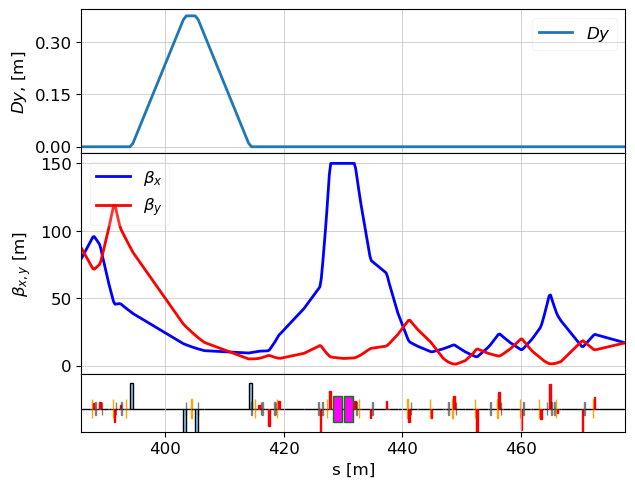

In [26]:
constr = {
    l2.marker_tds_b2: {"beta_x": 150, "alpha_x": 0},
    l2.otrb_457_b2: {"beta_x": 17},
    "delta": {
        l2.marker_tds_b2: ["mux", 0],
        l2.otrb_457_b2: ["mux", 0],
        "val": np.pi / 2,
        "weight": 1_000_007
    },
}

vars = [
    l2.qd_417_b2, 
    l2.qd_418_b2, l2.qd_425_b2, l2.qd_427_b2,
    l2.qd_431_b2, l2.qd_434_b2, l2.qd_437_b2, l2.qd_440_b2,
    l2.qd_444_b2, l2.qd_448_b2, l2.qd_452_b2, l2.qd_456_b2
]

match(lat, constr, vars, tw=tws_match_385, verbose=False, max_iter=1000, method='simplex')
tws = twiss(lat, tws0=tws_match_385)
plot_opt_func(lat, tws, top_plot=["Dy"], legend=False)
plt.show()

In [27]:
table = table_update(lat, tws_match_385, elements_for_comparision, attributes)
table

,TDS 429,Scr 450,Scr 454,Scr 457,Scr 461,end
beta_x,149.999988,10.171689,13.464320,17.000003,20.599334,16.913435
beta_y,5.393189,3.806096,9.257157,12.535284,10.352063,16.987023
alpha_x,0.000007,1.205647,-2.325239,1.641104,-2.786594,0.431733
alpha_y,0.077392,-1.485897,0.750044,-1.764348,2.139020,-0.749846
mux,0.000000,53.137548,78.537620,90.000197,104.864177,144.320683
muy,0.000000,189.144296,215.230574,240.547999,254.879356,415.898237
R12,0.000000,31.251759,44.044171,50.497527,53.726746,29.377497


### Matching to Final Conditions

We now restore the beam optics to match the original design values at the end of the beamline.

initial value: x =  [-1.1604708129787311, -0.5416290038832237, 1.335646848257458, -0.26307266377354444, -1.231144344594, 0.6503713981974811]
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 259
         Function evaluations: 434


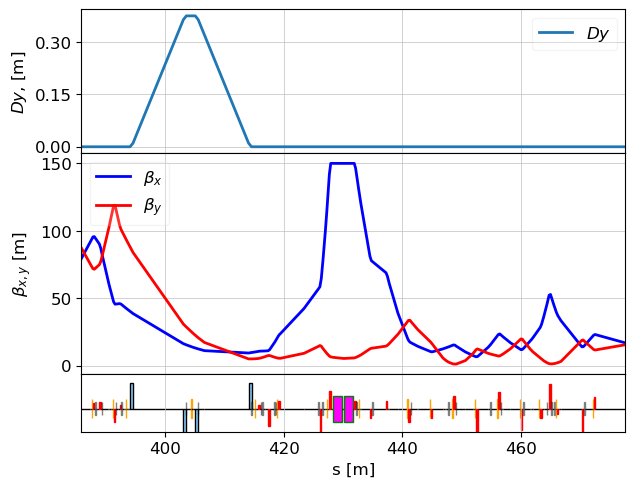

,TDS 429,Scr 450,Scr 454,Scr 457,Scr 461,end
beta_x,149.999988,10.171689,13.464320,17.000003,20.716989,16.882291
beta_y,5.393189,3.806096,9.257157,12.535284,10.246305,15.536480
alpha_x,0.000007,1.205647,-2.325239,1.641104,-2.825208,0.430299
alpha_y,0.077392,-1.485897,0.750044,-1.764348,2.155139,-0.609201
mux,0.000000,53.137548,78.537620,90.000197,104.843919,144.391133
muy,0.000000,189.144296,215.230574,240.547999,254.918264,417.566623
R12,0.000000,31.251759,44.044171,50.497527,53.885012,29.300154


In [28]:
constr_end = {
    END_ELEM: {
        "beta_x": tws_end.beta_x,
        "beta_y": tws_end.beta_y,
        "alpha_x": tws_end.alpha_x,
        "alpha_y": tws_end.alpha_y
     },
    #     "delta": {
        
    #     l2.otrb_457_b2: ["mux", 0],
    #     END_ELEM: ["mux", 0],
    #     "val": (790-690.22)/180*np.pi,
    #     "weight": 1_000_007
    # },
}

vars_end = [
    l2.qd_459_b2, 
    l2.qd_463_b2, l2.qd_464_b2, l2.qd_465_b2,
    l3.qd_470_b2, l3.qd_472_b2
]

match(lat, constr_end, vars_end, tw=tws_match_385, verbose=False, max_iter=2000, method='simplex')
tws_hi_res = twiss(lat, tws0=tws_match_385)
plot_opt_func(lat, tws_hi_res, top_plot=["Dy"], legend=False)
plt.show()
table = table_update(lat, tws_match_385, elements_for_comparision, attributes)
table

## Compare design and new optics

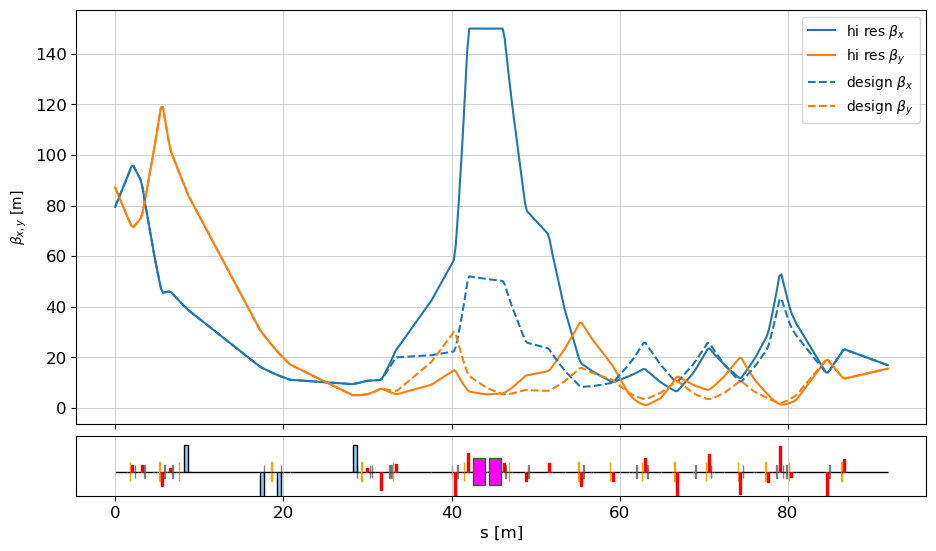

In [29]:
bx_n = [tw.beta_x for tw in tws_hi_res]
by_n = [tw.beta_y for tw in tws_hi_res]
s_n = np.array([tw.s for tw in tws_hi_res])
bx_d = [tw.beta_x for tw in tws_des]
by_d = [tw.beta_y for tw in tws_des]
s_d = np.array([tw.s for tw in tws_des])

fig, ax = plot_API(lat, legend=False, figsize=[10,6])

ax.plot(s_n - s_n[0], bx_n, 'C0', label=r"hi res $\beta_{x}$ ")
ax.plot(s_n - s_n[0], by_n, 'C1', label=r"hi res $\beta_{y}$ ")
ax.plot(s_d - s_d[0], bx_d, "C0--", label=r"design $\beta_{x}$ ")
ax.plot(s_d - s_d[0], by_d, "C1--", label=r"design $\beta_{y}$ ")
ax.set_ylabel(r"$\beta_{x,y}$ [m]")
ax.legend()
#plt.savefig("TDS_90m.png") 
plt.show()

In [30]:
for key in ['beta_x', "beta_y", "alpha_x", "alpha_y"]:
    print(key, " :", getattr(tws_hi_res[-1], key), getattr(tws_des[-1], key))

beta_x  : 16.882291323377554 16.882288192819743
beta_y  : 15.536480497394853 15.536499055076685
alpha_x  : 0.4302991727930746 0.4303020309015204
alpha_y  : -0.6092012060842842 -0.609204409231985


## Write to dataframe new quads kicks. Change name of `new_colimn`

In [31]:
WRITE_TO_FILE = True
REWRITE = True

beta_tds_ampl = constr[l2.marker_tds_b2]["beta_x"] 
new_column = f'TDS {beta_tds_ampl}m'


quads_kicks_df = pd.read_csv(df_filename, index_col=0)
# let's save design kicks to a dictionary
d_new = {}
for e in lat.sequence:
    if e.__class__ == Quadrupole:
        d_new[e.id] = e.k1
if WRITE_TO_FILE:
    if new_column in quads_kicks_df.columns and not REWRITE:
        print(f"Column '{new_column}' already exists. Skipping step.")
    else:
        print(f"Column '{new_column}' not found. Proceeding to add it.")
        quads_kicks_df[new_column] = pd.Series(d_new)
        quads_kicks_df.to_csv(df_filename)

quads_kicks_df

Column 'TDS 150m' not found. Proceeding to add it.


,design,TDS 70m,TDS 90m,TDS 120m,TDS 140m,TDS 150m
QD.387.B2,0.335173,0.335173,0.335173,0.335173,0.335173,0.335173
QD.388.B2,0.355996,0.355996,0.355996,0.355996,0.355996,0.355996
QD.391.B2,-0.725525,-0.725525,-0.725525,-0.725525,-0.725525,-0.725525
QD.392.B2,0.196996,0.196996,0.196996,0.196996,0.196996,0.196996
QD.415.B2,0.180686,0.180686,0.180686,0.180686,0.180686,0.180686
QD.417.B2,-0.750235,-0.784398,-0.844188,-0.925253,-0.878182,-0.971459
QD.418.B2,0.649193,0.584715,0.529610,0.462214,0.337036,0.409773
QD.425.B2,-1.300803,-1.347249,-1.304467,-1.251303,-1.156159,-1.308911
QD.427.B2,0.941484,0.961247,0.959889,0.955579,0.929976,0.990706
QD.431.B2,0.435183,0.438339,0.448529,0.446643,0.500821,0.443519


## Check optics again from dataframe 

In [32]:
quads_kicks_df = pd.read_csv(df_filename, index_col=0)
quads = list(quads_kicks_df.index)

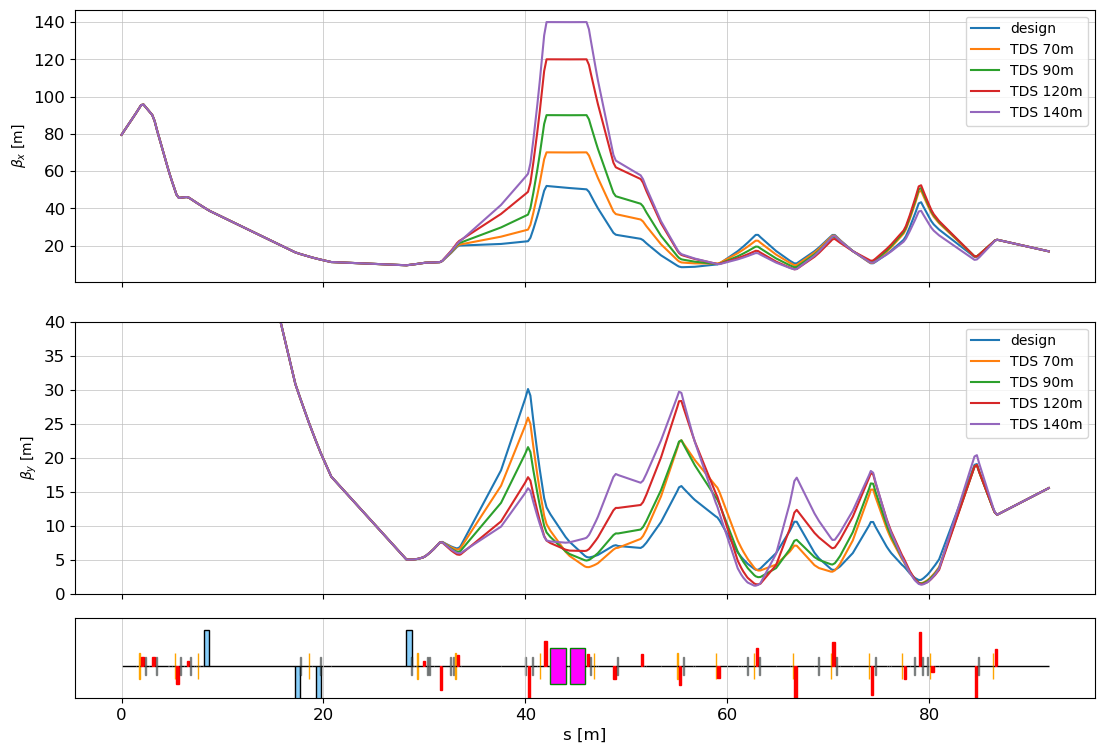

In [33]:
optics = list(quads_kicks_df.columns)
#optics.remove('TDS 70m')
#optics.remove('TDS 120m')
fig, (ax_extra, ax_xy) = plot_API(lat, figsize=(12,8), add_extra_subplot=True, legend=False)
ax_extra.set_ylabel(r"$\beta_x$ [m]")
ax_xy.set_ylabel(r"$\beta_y$ [m]")
data = {}
for opt in optics[:-1]:
    data[opt] = []
    for e in lat.sequence:
        if e.id in quads:
            e.k1 = quads_kicks_df[opt][e.id]

    tws = twiss(lat, tws0=tws_match_385)
    data[opt] = tws
    s = np.array([tw.s for tw in tws]) - tws[0].s
    bx = [tw.beta_x for tw in tws]
    by = [tw.beta_y for tw in tws]
    ax_extra.plot(s, bx, label=opt)
    ax_xy.plot(s, by, label=opt)
    ax_xy.set_ylim([0,40])
ax_xy.legend()
ax_extra.legend()
plt.show()

### Let’s Put Some Numbers to Understand the TDS Voltage (Streaking/Calibration Factor)

The streaking factor is given by:

$$
S = \frac{\sigma_x^{\text{scr}}}{c \sigma_t} = \frac{e V_0}{p c} \cdot \frac{2\pi}{\lambda} \cdot \sqrt{\beta_x(s_{\text{tds}}) \beta_x(s_{\text{scr}})} \cdot \sin(\Delta\Phi_x)
$$
or, as defined above, it can be rewritten using the transfer matrix element:
$$
S = \frac{\sigma_x^{\text{scr}}}{c \sigma_t} = \frac{e V_0}{p c} \cdot \frac{2\pi}{\lambda} \cdot R_{12}
$$

During experimental study of the proposed optics, we measured a calibration factor of
$S = 11.1$ mm/ps for our S-band TDS (operating at 3 GHz).
For optics TDS150m, we have $R_{12} = 50.5$ between the TDS and a screen (Scr 457).
Let’s calculate the required TDS voltage:

In [9]:
f = 3e9 # [Hz] frequency of the S-band TDS
S = 11.1e-3/1e-12 # [mm/ps] → [m/s]
R12 = 50.5 
Lrf = speed_of_light /f
pc = 2400 # [MeV] 

V = S * Lrf * pc /(R12 * 2 * np.pi* speed_of_light)
print(f"TDS voltage = {V} MV")

TDS voltage = 27.986057319921404 MV
